In [ ]:
import pandas as pd
import nltk

# Read the CSV file (fixed the quotes)
df = pd.read_csv("C:\\Users\\abcjv\\Downloads\\spotify_reviews.csv", usecols=['content', 'score'])

# Display the DataFrame
df

In [ ]:
# Function to convert rating stars to sentiment
def stars_to_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

# Ensure 'score' column exists before applying
if 'score' in df.columns:
    df['sentiment'] = df['score'].apply(stars_to_sentiment)
else:
    print("Error: Column 'score' not found in DataFrame.")

# Correct way to select multiple columns
df


In [ ]:
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Ensure necessary NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

# Contraction words
contractions = {
    "isn't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "hadn't": "had not", "isn't": "is not",
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mightn't": "might not",
    "mustn't": "must not", "needn't": "need not", "needn't": "need not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "wasn't": "was not", "weren't": "were not",
    "what's": "what is", "what'll": "what will", "what're": "what are", "what've": "what have",
    "where's": "where is", "where've": "where have", "who's": "who is", "who'll": "who will",
    "who're": "who are", "who've": "who have", "why's": "why is", "why're": "why are",
    "why've": "why have", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}

# Important words
sentiment_important_words = {
    "not", "no", "very", "good", "bad", "excellent", "love", "hate", "great", "feel", "wish", "would", "should"
}

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN if unknown
    
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions (assumes contractions dictionary is available)
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define English stopwords
    stop_words = set(stopwords.words('english'))

    # Customize the stopwords list for sentiment analysis (add negations or important words)
    stop_words = stop_words - sentiment_important_words  # Remove sentiment important words from stopwords

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Apply lemmatization based on POS tags and filter out stopwords and single-letter words
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
        if word.isalnum() and word not in stop_words and len(word) > 1  # Filter single-letter words
    ]

    # Join the lemmatized tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Test the function
df['processed_content'] = df['content'].apply(preprocess_text)
df

In [45]:
# Data augmentation Functions
import random

def get_synonym(word):
    """
    Returns a synonym for the given word that is different from the original word.
    If no synonym is found, returns the original word.
    """
    word_lower = word.lower()
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            lemma_name = lemma.name().lower()
            if lemma_name != word_lower:  # Ensure the synonym is different
                return lemma.name().replace("_", " ")  # Replace underscores with spaces
    return word  # Return original if no different synonym is found

def replace_random_words(sentence, num_words=2):
    """
    Replaces a specified number of random words in the sentence with their synonyms.
    """
    words = sentence.split()
    if not words:
        return sentence

    # Randomly select indices to replace, ensuring we don't exceed the number of words
    replace_indices = random.sample(range(len(words)), min(num_words, len(words)))
    
    for index in replace_indices:
        words[index] = get_synonym(words[index].lower())  # Convert to lowercase for matching
    
    return ' '.join(words)

def remove_random_words(sentence, num_words=2):
    """
    Removes random words from the sentence, prioritizing less important words.
    Does not remove words from the contractions dictionary or sentiment_important_words set.
    """
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)

    # Define important POS tags for sentiment (adjectives, verbs, adverbs, nouns)
    important_tags = {'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}

    # Combine contractions and sentiment-important words into a single set
    protected_words = set(contractions.keys()).union(sentiment_important_words)

    # Separate important and removable words
    removable_words = [
        word for word, tag in pos_tags
        if tag not in important_tags  # Not in important POS tags
        and word.lower() not in stopwords.words('english')  # Not a stopword
        and word.lower() not in protected_words  # Not in protected words
    ]

    # Remove up to `num_words` random removable words
    words_to_remove = random.sample(removable_words, min(num_words, len(removable_words)))

    # Filter out the words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]

    return ' '.join(filtered_tokens)

def random_insertion(sentence, num_insertions=2):
    """
    Inserts a synonym of a random word into the sentence at a random position.
    """
    tokens = word_tokenize(sentence)
    non_stopwords = [word for word in tokens if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    if not non_stopwords:
        return sentence  # No valid word found

    for _ in range(num_insertions):
        random_word = random.choice(non_stopwords)  # Pick a random non-stopword
        synonym = get_synonym(random_word)  # Get a synonym

        if not synonym or synonym.lower() == random_word.lower():
            continue  # Skip if no suitable synonym found

        insert_position = random.randint(0, len(tokens))  # Pick a random position
        tokens.insert(insert_position, synonym)  # Insert synonym at random position

    return ' '.join(tokens)

def random_swapping(sentence, num_swaps=2):
    tokens = word_tokenize(sentence)  # Tokenize the sentence
    words = [word for word in tokens if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    if len(words) < 2:
        return sentence  # Not enough words to swap

    for _ in range(num_swaps):
        # Select two random non-stopwords
        word1, word2 = random.sample(words, 2)

        # Find their positions in the original token list
        index1, index2 = tokens.index(word1), tokens.index(word2)

        # Swap their positions in the original tokens
        tokens[index1], tokens[index2] = tokens[index2], tokens[index1]

    return ' '.join(tokens)

def apply_augmentations(sentence):
    """
    Augments the sentence based on its length by applying random replacement, removal, insertion, and swapping.
    """
    # Preprocess the text (this includes lemmatization, stopword removal, etc.)
    preprocessed_sentence = preprocess_text(sentence)
    
    # Calculate the number of augmentations to perform based on sentence length
    num_words = len(preprocessed_sentence.split())
    
    # Determine how many augmentations to apply based on sentence length
    num_replacements = max(1, num_words // 2)  # Adjust as needed
    num_removals = max(1, num_words // 8)  # Adjust as needed
    num_insertions = max(1, num_words // 8)  # Adjust as needed
    num_swaps = max(1, num_words // 10)  # Adjust as needed

    # Apply augmentations based on calculated values
    sentence = replace_random_words(preprocessed_sentence, num_words=num_replacements)
    sentence = remove_random_words(sentence, num_words=num_removals)
    sentence = random_insertion(sentence, num_insertions=num_insertions)
    sentence = random_swapping(sentence, num_swaps=num_swaps)
    
    return sentence

In [54]:
from sklearn.utils import resample
from concurrent.futures import ThreadPoolExecutor

# Function to oversample and augment the data
def oversample_and_augment(sentiment_class, target_size, apply_augmentations, sentiment_name):
    oversampled = resample(sentiment_class, replace=True, n_samples=target_size, random_state=42)
    oversampled['processed_content'] = oversampled['processed_content'].apply(apply_augmentations)
    return oversampled

# Assuming 'df' is your original DataFrame
# Separate the data by sentiment
negative_samples = df[df['sentiment'] == 'negative']
neutral_samples = df[df['sentiment'] == 'neutral']
positive_samples = df[df['sentiment'] == 'positive']

# The target size for neutral and positive classes will be 1.5 times the size of the negative class
target_size_neutral_positive = int(len(negative_samples) * 1.5)

# Create a thread pool to process the classes in parallel
with ThreadPoolExecutor() as executor:
    futures = []
    futures.append(executor.submit(oversample_and_augment, neutral_samples, target_size_neutral_positive, apply_augmentations, 'Neutral'))
    futures.append(executor.submit(oversample_and_augment, positive_samples, target_size_neutral_positive, apply_augmentations, 'Positive'))

    # Collect the results
    neutral_oversampled = futures[0].result()
    positive_oversampled = futures[1].result()

# Combine the original negative samples with the oversampled neutral and positive samples
balanced_df = pd.concat([negative_samples, neutral_oversampled, positive_oversampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['sentiment'].value_counts())  # Check class balance

sentiment
neutral     73359
positive    73359
negative    48906
Name: count, dtype: int64


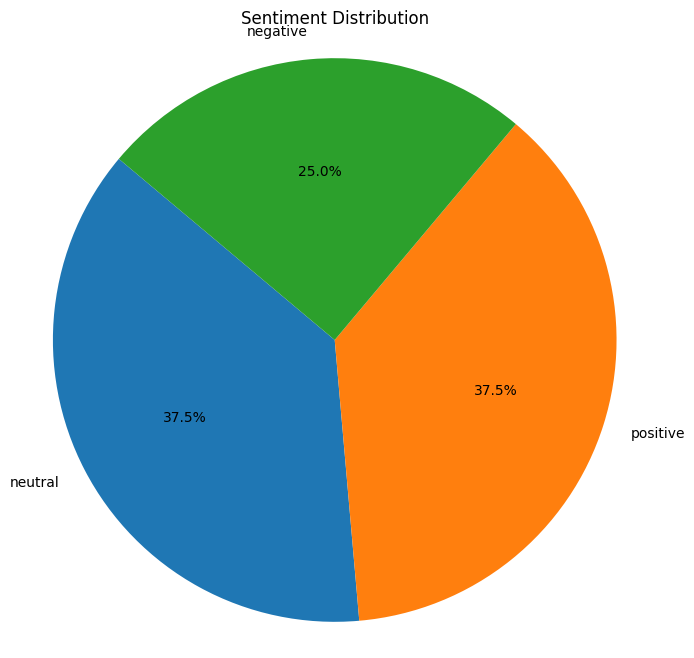

In [55]:
from matplotlib import pyplot as plt
import numpy as np

# Count the number of occurrences for each sentiment category
sentiment_count = balanced_df['sentiment'].value_counts()

plt.figure(figsize=(8, 8))  # Set the figure size

# Create a pie chart to visualize sentiment distribution
plt.pie(sentiment_count, labels=sentiment_count.index, autopct="%1.1f%%", startangle=140)

plt.title('Sentiment Distribution')  # Add a title to the chart
plt.axis('equal')  # Ensure the pie chart is displayed as a circle
plt.show()  # Display the plot

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(balanced_df['processed_content'], balanced_df['sentiment'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer with bigrams, minimum document frequency of 3, and max document frequency of 90%
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, sublinear_tf=True)

# Fit the vectorizer on training data and transform it into numerical feature vectors
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vectorized, y_train)
preds = rf.predict(X_test_vectorized)
print(classification_report(y_test, preds))

In [ ]:
def predict_sentiment(review):
    processed_review = preprocess_text(review)
    vectorized_review = vectorizer.transform([processed_review])
    sentiment = rf.predict(vectorized_review)[0]
    return sentiment

In [ ]:
new_review = """

it is decent

"""
print("Predicted sentiment:", predict_sentiment(new_review))

Predicted sentiment: positive
